### Advanced Machine Learning

# Final Assignment  - Detect True vs False Stories (lie detection)

Assignment Start: 11/07/21 00:00<br>
Assignment Due: 18/07/21 23:59 (moodle will be closed for submissions that time)

Jonathan Schler


In [1]:
id="337839112"
name="Sofya Zubtsovsky"

## Introduction
You are provided with a labeled corpus of narratives in Hebrew. The corpus is provided as a csv file. Each row represents a narrative. It has 5 fields: id, author_gender, author_birth_year, narrative and label. The label for each narrative indicates whether this is a true or false story (i.e. the author lied when he told the story) (label "1" for True, and "0" for false). 

You are requested to build a model to predict whether a new story in Hebrew is true or false (i.e a lie). You are provided with 2 files: 
- `train_dataset.csv` - which contains **labeled** examples, and 
- `test_dataset.csv` that contains **unlabled** examples that you'll have to classify and submit the results. The narrtives in this file will have the same fields except of the label field.

(you'll be graded based on the quality of the labels assigned to the `test_dataset.csv`).





## What is expected from you
1. Build a classifier (including all pre-processing steps - as you think may fit (feature engineering, pre-processing, scaling etc) ) that will classify an unlabled document (including reasonable documentation for the steps you chose to do)
2. Report on how you chose to evaluate your algorithm and the scores of that evaluation
3. Apply the model on the unlabeled data set (`test_dataset.csv`), and return the results in the format described below
4. At the end, you are requested to submit 2 files: (a) this notebook, and (b) the output csv file. Submission will be done via moodle. The output csv is the file, that contains the prediction for the `test_dataset.csv`. The naming of the file should be `<your_id_number>.csv` (where `<your_id_number>` will be replaced with you actual ID number). The file will contain for each doc a label `1` (for true narratives) or `0` (for false narratives) (such that each row contains only one label, corresponding to the document in the given row in the `test_dataset.csv` document). You can see a sample output file under the name `123456789.csv` in the moodle.

## Grading Guidelines
1. Overall approach and workable solution (70 pts)
2. Average f1 score of higher than 0.50 (10 pts)
3. Average f1 score of higher than 0.58 (additional 5 pts)
4. Competitive element: 15 Highest average f1 score - will get additional 15 pts, top score the extra 15 points, second highest - extra 14 points etc - in case of similar scores it will be divided proportionaly.

## Other Guidelines
1. Work in indivudual, collaboration is not allowed. 
2. You are allowed to use all the toolsets we learned / mentioned in class, in addition to any other avialble toolsets for text processing or Hebrew data as you think is appropriate.


## Good Luck!

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.preprocessing import normalize, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
pd.options.display.float_format = '{:f}'.format

In [3]:
# utilities function are same as were implemented
# with Alexander Kruglyak for assigments during the semester

def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(df.describe())
    print("\n" + "*" * 10 + "\n")
    
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['label']
    df = drop_columns(df,['label'])
    return df, label

def show_random_text(_df,feature,n=1):
    df = _df.sample(n=n,random_state=42)
    print(list(df[feature]))
    
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        full_scores = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=10,
            scoring=('roc_auc', 'average_precision', 'recall', 'f1'),
            n_jobs = -1
        )
        add_score(scores_df, full_scores, estimator.__class__.__name__,prefix)
        
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'recall'] = scores['test_recall'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

In [4]:
df_steps = {}

In [5]:
df_steps['0_full_df'] = pd.read_csv("train_dataset.csv")

## Step 1 - get familiar with the data

In [6]:
show_data_basic_information(df_steps['0_full_df'])

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         408 non-null    int64 
 1   author_gender      408 non-null    object
 2   author_birth_year  408 non-null    int64 
 3   narrative          408 non-null    object
 4   label              408 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 16.1+ KB
None

**********

Shape

(408, 5)

**********

Amount of is null data

0

**********

Describe



,Unnamed: 0,author_birth_year,label
count,408.000000,408.000000,408.000000
mean,203.500000,1993.573529,0.500000
std,117.923704,3.370560,0.500614
min,0.000000,1980.000000,0.000000
25%,101.750000,1992.750000,0.000000
50%,203.500000,1994.000000,0.500000
75%,305.250000,1995.000000,1.000000
max,407.000000,2002.000000,1.000000



**********



In [7]:
df_steps['0_full_df']

,Unnamed: 0,author_gender,author_birth_year,narrative,label
0,0,זכר,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1
1,1,זכר,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1
2,2,זכר,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1
3,3,נקבה,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1
4,4,נקבה,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1
...,...,...,...,...,...
403,403,זכר,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0
404,404,זכר,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0
405,405,זכר,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0
406,406,נקבה,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0


## Initial processing:
- drop 'Unnamed 0' column
- encode author_gender
- add feature - length of the narrative
- (?) - replace birth year with age

In [8]:
def encode_gender(_df):
    df = _df.copy()
    man = "זכר"
    woman = "נקבה"
    gender = {man: 0, woman: 1}
    df['author_gender'] = [gender[item] for item in df['author_gender']]
    return df

In [9]:
def add_length_of_narrative(_df):
    df = _df.copy()
    df['nar_length'] = df['narrative'].str.len()
    return df

In [10]:
# def convert_year_to_age(_df):
#     df = _df.copy()
#     df['nar_length'] = df['narrative'].str.len()
#     return df

In [11]:
df_steps['1_dropped'] = drop_columns(df_steps['0_full_df'],['Unnamed: 0'])
df_steps['2_gender'] = encode_gender(df_steps['1_dropped'])
df_steps['3_nar_length'] = add_length_of_narrative(df_steps['2_gender'])
df_steps['3_nar_length']

,author_gender,author_birth_year,narrative,label,nar_length
0,0,1995,"שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה ...",1,1748
1,0,1992,בשנת 2018 קיבלתי החלטה שאני מתחיל ללמוד לתואר ...,1,1696
2,0,1992,לפני מספר שנים אני ובת הזוג שלי טסנו ללונדון ז...,1,1967
3,1,1991,"האישה שבקושי הכרתי חייכה תמיד, העיניים שלה ברק...",1,1648
4,1,1992,בדרך חזרה מהטיול שנתי בכיתה ח' התקשרתי לאבא של...,1,1553
...,...,...,...,...,...
403,0,1988,"ללמוד להעז יותר, אחד החוויה הזאת שעשיתי באה אח...",0,2561
404,0,1993,זה קרה לפניי מספר שבועות עוד כשהיינו תחת סגרים...,0,1670
405,0,1995,"לפני שלוש שנים, לאחר שחסכתי, טסתי עם חבר מאוד ...",0,2032
406,1,1993,כשהייתי ילדה קטנה בבית הספר בגיל 8 הייי ילדה מ...,0,1457


- Plot see the distribution of the data

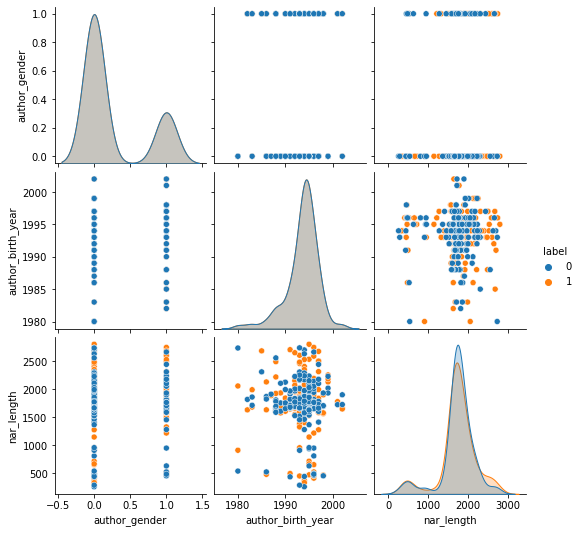

In [12]:
sns.pairplot(df_steps['3_nar_length'], hue='label')

Text(0.5, 1.0, 'Class Distributions \n (0: False || 1: True)')

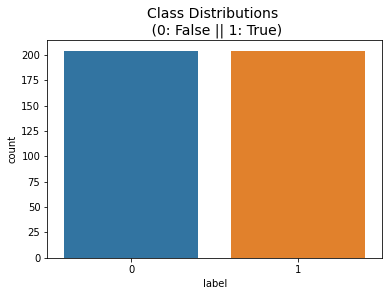

In [13]:
sns.countplot(x='label',data=df_steps['3_nar_length'])
plt.title('Class Distributions \n (0: False || 1: True)', fontsize=14)

In [14]:
show_random_text(df_steps['3_nar_length'],'narrative',2)

['בשנה האחרונה חווינו את השפעותיו של נגיף הקורונה, לפני כשנה התארסתי לאחר שהייתי בזוגיות של 4 שנים. קבענו את התאריך לחתונה לשנה קדימה . עקב מקרה אישי במשפחה נאצלנו להקדים את החתונה בכשלושה חודשים . בגלל הקורונה היה מצב של חוסר וודאות מוחלט בו היינו בסגר על פי הנחיות המדינה. קבענו את התאריך החדש לחודש מרץ . כשבוע לפני החתונה מספר מחוסנים במדינה עמד על כ3 מיליון , עקב המספר הגבוה הוחלט לפתוח את המשק כשבוע לפני החתונה שלנו . בשבוע הראשון של המתווה התחתנו . החתונה התקיימה ביום שישי , המזג אוויר היה לא מוחלט, כל הלילה היה סערה ואנחנו חששנו כיוון שקבענו את החתונה במקום פתוח , לא ידענו האם ירד גשם או לא . התפללנו למזג אוויר טוב. בהתחלה האורחים התלוננו על מזג אוויר קר ורוחות חזקות - אנחנו התבאסנו חשבנו שאנשים לא ייהנו . בהמשך האירוע המזג אוויר התבהר. בחופה פגשנו את הרב לראשונה , עקב הקורונה ותכנון החתונה המהיר שעשינו תוך חודשיים , לא פגשנו אותו ובקושי דיברנו איתו בטלפון. התרשמנו ממנו לטובה הוא נתן לשנינו להעניק זה לזו את הטבעת. לקראת שבירת הכוס החתן נורא חשש שלא ישבור את הכוס, בכל זאת זה השיא 

## Conclustion from step 1
- data is balanced
- there is no significant differences between features distribution per label
- narrative has to be cleaned from \n

In [18]:
df_steps['4_clean_nar'] = df_steps['3_nar_length']
df_steps['4_clean_nar']['narrative'] = df_steps['4_clean_nar']['narrative'].replace(b"<br />", b" ")
df_steps['4_clean_nar']['narrative'] = df_steps['4_clean_nar']['narrative'].replace("n\\",' ')

In [19]:
show_random_text(df_steps['4_clean_nar'],'narrative',2)

['בשנה האחרונה חווינו את השפעותיו של נגיף הקורונה, לפני כשנה התארסתי לאחר שהייתי בזוגיות של 4 שנים. קבענו את התאריך לחתונה לשנה קדימה . עקב מקרה אישי במשפחה נאצלנו להקדים את החתונה בכשלושה חודשים . בגלל הקורונה היה מצב של חוסר וודאות מוחלט בו היינו בסגר על פי הנחיות המדינה. קבענו את התאריך החדש לחודש מרץ . כשבוע לפני החתונה מספר מחוסנים במדינה עמד על כ3 מיליון , עקב המספר הגבוה הוחלט לפתוח את המשק כשבוע לפני החתונה שלנו . בשבוע הראשון של המתווה התחתנו . החתונה התקיימה ביום שישי , המזג אוויר היה לא מוחלט, כל הלילה היה סערה ואנחנו חששנו כיוון שקבענו את החתונה במקום פתוח , לא ידענו האם ירד גשם או לא . התפללנו למזג אוויר טוב. בהתחלה האורחים התלוננו על מזג אוויר קר ורוחות חזקות - אנחנו התבאסנו חשבנו שאנשים לא ייהנו . בהמשך האירוע המזג אוויר התבהר. בחופה פגשנו את הרב לראשונה , עקב הקורונה ותכנון החתונה המהיר שעשינו תוך חודשיים , לא פגשנו אותו ובקושי דיברנו איתו בטלפון. התרשמנו ממנו לטובה הוא נתן לשנינו להעניק זה לזו את הטבעת. לקראת שבירת הכוס החתן נורא חשש שלא ישבור את הכוס, בכל זאת זה השיא 

## Step 2 - tokenize the narrative
exaustive search for the best model

In [20]:
text_train = df_steps['4_clean_nar']['narrative'].tolist()
y_train = df_steps['4_clean_nar']['label']

In [21]:
text_train

['שנת 2020 הייתה מטלטלת למדי בשבילי, עברתי הרבה מאוד חוויות בה, בין אם הן חיוביות או לעומת זאת שליליות, חלקן היו בעלות אופי דו משמעי, כלומר לעיתים חיובי ולחילופין שלילי. אחת החוויות היותר משפיעות הייתה מעבר מוסד לימודים, אפשר לסייג אותה בתור חוויה חיובית באופן כללי אך כמו שספרתי קודם לכן היו בה רגעים פחות חיוביים ואפילו שליליים למדי.\nזה היה למעשה מעבר מאוניברסיטה נחשבת מאוד למכללה מקצועית לא פחות אך עם שם איך נאמר פחות מפורסם ופחות יוצא מן השורות הראשונות של הקידמה האדמית בארץ ובכלל בעולם.\nהמעבר הזה הכה חזק באגו ואף נגע בתדמית שלי, אפשר להגיד את זה בצורה ישירה ובדוקה שזו גם דעת הכלל על הפן המקצועי שלי.\nאני סובר שהחלק שהיה הכי משמעותי במכה הזאת הוא הציונים בקורסים השונים, כנראה שזה קרה כך כי מאחורי הקלעים אני הייתי מצפה להעלות את הציונים עקב הירידה בקושי האקדמי המשתמע מן השינוי אך זה לא קרה, שאלתי את עצמי מדוע זה כך פעמים רבות וטרם הבנתי את התשובה לכך.\nהלימודים במוסד החדש היו במתכונת רחוקה בלבד, למדתי שעות ורבות ואכן השקעתי את רוב כוחותיי במשימות והאתגרים, טוב, אם להיות כנה עד הסוף,

In [22]:
vect = CountVectorizer(min_df=4)
X_train = vect.fit_transform(text_train)
X_train

<408x4342 sparse matrix of type '<class 'numpy.int64'>'
	with 70138 stored elements in Compressed Sparse Row format>

In [23]:
#Vocabulary
feature_names = vect.get_feature_names()
print(feature_names[:10])
print(feature_names[20000:20020])
print(feature_names[::2000])

['00', '000', '10', '100', '1000', '11', '12', '13', '14', '15']
[]
['00', 'חלק', 'שהרבה']


In [24]:
lr = LogisticRegression(n_jobs=-1).fit(X_train, y_train)
lr.score(X_train,y_train)

1.0

In [25]:
regressors = [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
]
scores_df = pd.DataFrame(dtype=float)

In [26]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"count_vectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [27]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
SGDClassifier_count_vectorizer,0.508909,0.556548,0.504524,0.585910
PassiveAggressiveClassifier_count_vectorizer,0.520934,0.558238,0.530000,0.592741
LogisticRegression_count_vectorizer,0.522817,0.555738,0.529762,0.581970
RidgeClassifierCV_count_vectorizer,0.528617,0.549357,0.535000,0.579483
Perceptron_count_vectorizer,0.540853,0.567696,0.563571,0.595002


In [28]:
#TfidfVectorizer
tdif = TfidfVectorizer(min_df=4)
X_train = tdif.fit_transform(text_train)

In [34]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"TfidfVectorizer")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [35]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
LogisticRegression_count_vectorizer,0.522817,0.555738,0.529762,0.581970
LogisticRegressionCV_TfidfVectorizer,0.526600,0.566964,0.525000,0.601036
RidgeClassifierCV_count_vectorizer,0.528617,0.549357,0.535000,0.579483
Perceptron_count_vectorizer,0.540853,0.567696,0.563571,0.595002
Perceptron_TfidfVectorizer,0.565695,0.571929,0.647857,0.602859


In [43]:
# L1 normalization with CountVectorizer
count_vec = CountVectorizer(min_df=4)
X_train = count_vec.fit_transform(text_train)
X_train = normalize(X_train,norm="l1")

In [44]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"TfidfVectorizer_norm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [45]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
LogisticRegressionCV_TfidfVectorizer,0.526600,0.566964,0.525000,0.601036
RidgeClassifierCV_count_vectorizer,0.528617,0.549357,0.535000,0.579483
Perceptron_count_vectorizer,0.540853,0.567696,0.563571,0.595002
Perceptron_TfidfVectorizer_norm,0.565695,0.571929,0.647857,0.602859
Perceptron_TfidfVectorizer,0.565695,0.571929,0.647857,0.602859


In [46]:
#ngrams
ngrm = CountVectorizer(ngram_range=(1, 3), min_df=4)
X_train = ngrm.fit_transform(text_train)

In [47]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"ngrm")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [48]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
Perceptron_count_vectorizer,0.540853,0.567696,0.563571,0.595002
LogisticRegression_ngrm,0.541068,0.582762,0.544762,0.606915
RidgeClassifier_ngrm,0.543005,0.581738,0.544762,0.604912
Perceptron_TfidfVectorizer_norm,0.565695,0.571929,0.647857,0.602859
Perceptron_TfidfVectorizer,0.565695,0.571929,0.647857,0.602859


In [49]:
cv = CountVectorizer(ngram_range=(1, 3), analyzer="char_wb")
X_train = cv.fit_transform(text_train)
print(f"vocaulary size:{len(cv.vocabulary_)}")

vocaulary size:12592


In [50]:
for regr in regressors:
    get_cross_val_score(scores_df,regr, X_train, y_train,"_char_wb")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [51]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
LogisticRegression_ngrm,0.541068,0.582762,0.544762,0.606915
RidgeClassifier_ngrm,0.543005,0.581738,0.544762,0.604912
SGDClassifier__char_wb,0.563777,0.579619,0.661190,0.589578
Perceptron_TfidfVectorizer,0.565695,0.571929,0.647857,0.602859
Perceptron_TfidfVectorizer_norm,0.565695,0.571929,0.647857,0.602859


Get an impression of data by looking at most important features

In [55]:
tdif = TfidfVectorizer(stop_words='english',min_df=4)
X_train = tdif.fit_transform(text_train)

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [53]:
def plot_important_features(coef, feature_names, top_n=20, ax=None, rotation=60):
    if ax is None:
        ax = plt.gca()
    inds = np.argsort(coef)
    low = inds[:top_n]
    high = inds[-top_n:]
    important = np.hstack([low, high])
    myrange = range(len(important))
    colors = ['red'] * top_n + ['blue'] * top_n
    
    ax.bar(myrange, coef[important], color=colors)
    ax.set_xticks(myrange)
    ax.set_xticklabels(feature_names[important], rotation=rotation, ha="right")
    ax.set_xlim(-.7, 2 * top_n)
    ax.set_frame_on(False)

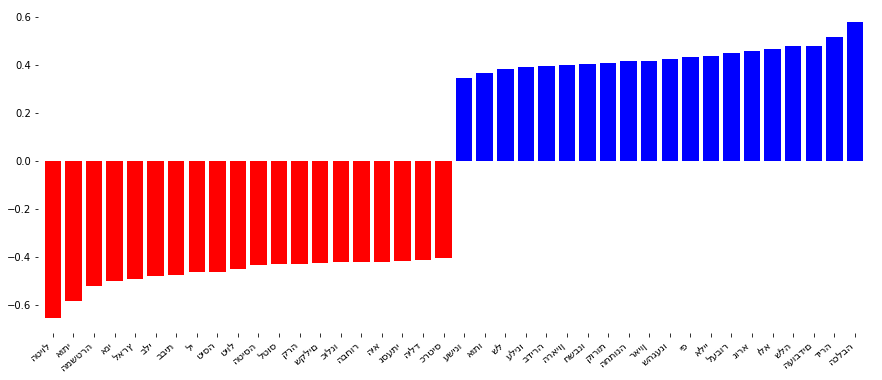

In [59]:
plt.figure(figsize=(15, 6))
plot_important_features(lr.coef_.ravel(), np.array(tdif.get_feature_names()), top_n=20, rotation=40)
ax = plt.gca()
plt.show()

In [60]:
X,y=get_label_and_drop(df_steps['4_clean_nar'])

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=101,stratify=y)

In [65]:
def get_num_text_pipeline(df,regr_num,regr_text):
    numeric_cols = X_train.columns[X_train.columns.dtype != object].tolist()
    
    transformer_text = FunctionTransformer(lambda x: x['narrative'], validate=False)
    transfomer_numeric = FunctionTransformer(lambda x: x[numeric_cols], validate=False)

    pipeline = Pipeline([
        ('features', FeatureUnion([
                ('numeric_features', Pipeline([
                    ('selector', transfomer_numeric)
                ])),
                 ('text_features', Pipeline([
                    ('selector', transformer_text),
                    (regr_text.__class__.__name__, regr_text)
                ]))
             ])),
        ('estimator', regr_num)
    ])
    return pipeline

In [67]:
regr_text = TfidfVectorizer(min_df=4)

for regr in regressors:
    pipe = get_num_text_pipeline(X_train,regr,regr_text)
    get_cross_val_score(scores_df,pipe, X_train, y_train,regr_text.__class__.__name__+"_combined")

*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********
*********Pipeline *********


In [68]:
display(scores_df.sort_values(by='f1').tail(5))

,f1,roc_auc,recall,average_precision
LogisticRegression_ngrm,0.541068,0.582762,0.544762,0.606915
RidgeClassifier_ngrm,0.543005,0.581738,0.544762,0.604912
SGDClassifier__char_wb,0.563777,0.579619,0.661190,0.589578
Perceptron_TfidfVectorizer,0.565695,0.571929,0.647857,0.602859
Perceptron_TfidfVectorizer_norm,0.565695,0.571929,0.647857,0.602859


meantime combined featues haven't improved the results so far...

## spaCy

In [71]:
import spacy # is it relevant for hebrew? TBD check what we saw on a class on hebrew

In [72]:
nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "ner","lemmatizer"])